In [187]:
!pip install tensorflow

In [188]:
import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import accuracy_score, mean_poisson_deviance, mean_gamma_deviance
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [189]:
btcdf = pd.read_csv('BTC.csv')

In [190]:
btcdf.shape

(2836, 7)

In [191]:
btcdf.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-01,963.658020,1003.080017,958.698975,998.325012,998.325012,147775008
1,2017-01-02,998.617004,1031.390015,996.702026,1021.750000,1021.750000,222184992
2,2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,1043.839966,185168000
3,2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,1154.729980,344945984
4,2017-01-05,1156.729980,1191.099976,910.416992,1013.380005,1013.380005,510199008


In [192]:
btcdf.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2831,2024-10-02,60836.324219,62357.687500,59996.949219,60632.785156,60632.785156,40762722398
2832,2024-10-03,60632.484375,61469.039062,59878.804688,60759.402344,60759.402344,36106447279
2833,2024-10-04,60754.625000,62465.992188,60459.941406,62067.476562,62067.476562,29585472513
2834,2024-10-05,62067.609375,62371.023438,61689.582031,62089.949219,62089.949219,13305410749
2835,2024-10-06,62084.988281,62959.570312,61833.148438,62818.953125,62818.953125,14776233667


In [193]:
btcdf.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2836.000000,2836.000000,2836.000000,2836.000000,2836.000000,2.836000e+03
mean,23241.696396,23767.721452,22681.085905,23262.039342,23262.039342,2.287903e+10
std,19766.306933,20199.763573,19290.278300,19773.829052,19773.829052,1.888917e+10
min,775.177979,823.307007,755.755981,777.757019,777.757019,6.085170e+07
25%,7277.492554,7435.214966,7113.698975,7277.790405,7277.790405,7.730409e+09
50%,16601.785156,16804.058594,16284.663574,16603.525391,16603.525391,2.026586e+10
75%,37470.646484,38601.096680,36421.379883,37493.499023,37493.499023,3.252037e+10
max,73079.375000,73750.070312,71334.093750,73083.500000,73083.500000,3.509679e+11


In [194]:
btcdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2836 entries, 0 to 2835
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2836 non-null   object 
 1   Open       2836 non-null   float64
 2   High       2836 non-null   float64
 3   Low        2836 non-null   float64
 4   Close      2836 non-null   float64
 5   Adj Close  2836 non-null   float64
 6   Volume     2836 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 155.2+ KB


In [195]:
print('Total number of days:' , btcdf.shape[0])
print('Total number of fields present:' , btcdf.shape[1])

Total number of days: 2836
Total number of fields present: 7


In [196]:
print('Null Values: ', btcdf.isnull().values.sum())

Null Values:  0


In [197]:
closedf = btcdf[['Date', 'Close']]
print("shape of closed df: ", closedf.shape)

shape of closed df:  (2836, 2)


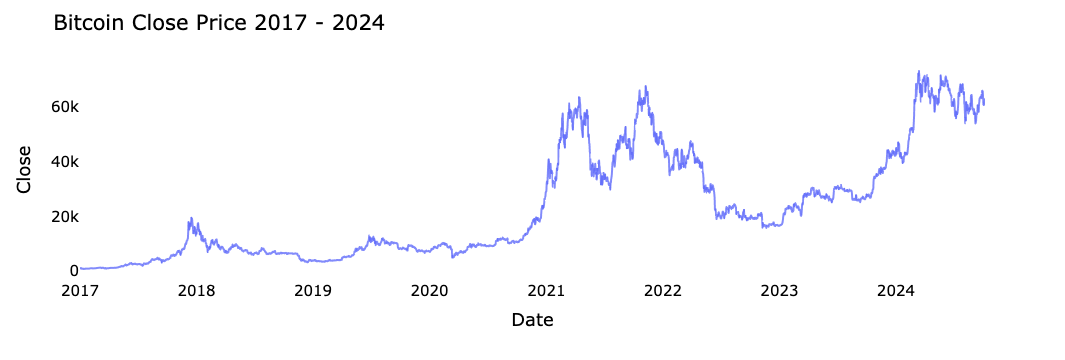

In [198]:
fig = px.line(closedf, x=closedf.Date, y=closedf.Close,labels={'date':'Date','close':'Close Stock'})
fig.update_traces(marker_line_width=3, opacity=0.8, marker_line_color='blue')
fig.update_layout(title_text='Bitcoin Close Price 2017 - 2024', plot_bgcolor='white', 
                  font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [199]:
# Transform Data
del closedf['Date']

scaler = MinMaxScaler(feature_range=(0,1))
closedf['Close'] = scaler.fit_transform(np.array(closedf['Close']).reshape(-1,1))
print(closedf.shape)

(2836, 1)


/var/folders/4c/vyr3wb1x6tn91c28270fqk000000gn/T/ipykernel_94495/778609543.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [200]:
train_size = int(len(closedf) * 0.8)
test_size =  len(closedf) - train_size

train_data = closedf.iloc[0:train_size, :]
test_data = closedf.iloc[train_size:len(closedf), :]

print('Training Data: ', train_data.shape)
print('Test Data: ', test_data.shape)

Training Data:  (2268, 1)
Test Data:  (568, 1)


In [201]:
def create_dataset(dataset, time_step):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset.iloc[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset.iloc[i + time_step, 0]) 
    return np.array(dataX), np.array(dataY)

In [202]:
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)

X_train:  (2252, 15)
y_train:  (2252,)
X_test:  (552, 15)
y_test:  (552,)


In [203]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (2252, 15, 1)
X_test:  (552, 15, 1)


In [204]:
model = Sequential()

model.add(Input(shape=(None, 1)))  
model.add(LSTM(10, activation="relu"))
model.add(Dense(1))

model.compile(loss="mean_squared_error", optimizer="adam")

In [259]:
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=1000, batch_size=32, verbose=1)

Epoch 1/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5734e-04 - val_loss: 3.6716e-04
Epoch 2/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6883e-04 - val_loss: 3.5540e-04
Epoch 3/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0197e-04 - val_loss: 3.3031e-04
Epoch 4/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9137e-04 - val_loss: 3.8683e-04
Epoch 5/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7637e-04 - val_loss: 3.2130e-04
Epoch 6/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6553e-04 - val_loss: 3.3736e-04
Epoch 7/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9202e-04 - val_loss: 3.6764e-04
Epoch 8/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0112e-04 - val_loss: 3.3000e-04
Epoch 9/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2163e-04 - val_loss: 3.1862e-04
Epoch 10/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7355e-04 - val_loss: 3.2143e-04
Epoch 11/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss

In [261]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 643us/step


((2252, 1), (552, 1))

In [263]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

In [265]:
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))

print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))

print("Predicted Value after Training:", train_predict)
print("Predicted Value after Testing:", test_predict)


Train data RMSE:  950.8830438851933
-------------------------------------------------------------------------------------
Test data RMSE:  1337.7307411771492
Predicted Value after Training: [[ 1030.7737]
 [ 1039.7106]
 [ 1103.1583]
 ...
 [25000.547 ]
 [24803.408 ]
 [25415.398 ]]
Predicted Value after Testing: [[28518.008]
 [28106.453]
 [28414.855]
 [28438.799]
 [28313.023]
 [28192.645]
 [28202.05 ]
 [28565.445]
 [29839.04 ]
 [30516.703]
 [30525.979]
 [30783.23 ]
 [30864.557]
 [30696.133]
 [30660.334]
 [29803.678]
 [30636.965]
 [29161.012]
 [28525.754]
 [27545.428]
 [28000.834]
 [27815.42 ]
 [27745.842]
 [28489.14 ]
 [28657.719]
 [29691.428]
 [29671.838]
 [29614.822]
 [29614.951]
 [28478.137]
 [28935.229]
 [29251.014]
 [29116.334]
 [29771.15 ]
 [29226.01 ]
 [28772.168]
 [27992.94 ]
 [27900.947]
 [27855.02 ]
 [27261.94 ]
 [27036.955]
 [27006.871]
 [27148.328]
 [27410.79 ]
 [27286.848]
 [27623.156]
 [27123.074]
 [27145.652]
 [27372.932]
 [27029.879]
 [27095.332]
 [27456.18 ]
 [26640.074]
